<a href="https://colab.research.google.com/github/as9786/ComputerVision/blob/main/ImageSegmentation/code/FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"as9786","key":"6d0e4d71104016c09317cf88e4f524b3"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

100% 9.55G/9.58G [00:49<00:00, 256MB/s]
100% 9.58G/9.58G [00:49<00:00, 209MB/s]


In [5]:
!unzip chest-xray-masks-and-labels.zip

Archive:  chest-xray-masks-and-labels.zip
  inflating: Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0001_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0002_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0003_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0004_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0005_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0006_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0007_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0008_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0009_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0010_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0011_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0012_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0013_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0014_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0015_0

# Module

In [58]:
import random
import os

from PIL import Image
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt  
from torchsummary import summary as model_summary
from sklearn.model_selection import train_test_split
import torchvision

import torch 
import torch.nn as nn
import torch.nn.functional as F

import time

# 장치

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset

In [64]:
root_path = '/content/Lung Segmentation'
model_save_path = './FCN_v2.pth'
CXR_path = os.path.join(root_path, 'CXR_png')
MASK_path = os.path.join(root_path, 'masks')

Dataset 자체에 orginal image와 mask의 개수가 다르므로 공통적으로 있는 것들에 대해서 뽑아옴

In [10]:
CXR_list = sorted(os.listdir(CXR_path))
MASK_list = sorted(os.listdir(MASK_path))

# mask name
MASK_list_ = list(map(lambda x:x.split('.')[0][:-5]+'.png', MASK_list))
# 공통적인 data 찾기
CXR_MASK_union_list = set(MASK_list_) & set(CXR_list)

CXR_path_list = sorted(list(map(lambda x:os.path.join(root_path, 'CXR_png', x), CXR_MASK_union_list)))
MASK_path_list = sorted(list(map(lambda x:os.path.join(root_path, 'masks', x.split('.')[0]+'_mask.png'), CXR_MASK_union_list)))

print(len(CXR_path_list), CXR_path_list[:1])
print(len(MASK_path_list), MASK_path_list[:1])

566 ['/content/Lung Segmentation/CXR_png/CHNCXR_0001_0.png']
566 ['/content/Lung Segmentation/masks/CHNCXR_0001_0_mask.png']


## Holdout

In [11]:
X, X_test, y, y_test = train_test_split(CXR_path_list, MASK_path_list, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
print(len(X_train), len(X_val), len(X_test))

samplex = torchvision.io.read_image(X_train[0])
sampley = torchvision.io.read_image(y_train[0])
print(samplex.shape, samplex.dtype)
print(sampley.shape, sampley.dtype, np.unique(sampley))

356 40 170
torch.Size([1, 2278, 2301]) torch.uint8
torch.Size([1, 2278, 2301]) torch.uint8 [  0 255]


폐인 부분은 255 나머지는 0으로 masking 되어 있음

In [12]:
from torch.utils.data import Dataset, DataLoader

In [13]:
class LungDataset(Dataset):
  def __init__(self, img_dir, mask_dir, transforms_x):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.transforms_x = transforms_x

    assert len(img_dir) == len(mask_dir)

  def __len__(self):
    return len(self.img_dir)
  
  def __getitem__(self,idx):
    X = Image.open(self.img_dir[idx]).convert('RGB')
    X = X.resize((224,224))

    y = Image.open(self.mask_dir[idx])
    y = y.resize((224,224),Image.NEAREST)
    y = np.array(y)
    y = torch.from_numpy(y)
    y[y==255] = 1
    y_one_hot = F.one_hot(y.to(torch.int64))
    y_one_hot = y_one_hot.permute(2,0,1).to(torch.float)

    if self.transforms_x:
      X = self.transforms_x(X)


    return X, y_one_hot

In [14]:
from torchvision import transforms as transform

In [15]:
transforms_x  = transform.Compose([
    transform.ToTensor()
])

In [16]:
train_data = LungDataset(X_train,y_train,transforms_x=transforms_x)
valid_data = LungDataset(X_val,y_val,transforms_x=transforms_x)
test_data = LungDataset(X_test,y_test,transforms_x=transforms_x)

In [17]:
train_loader = DataLoader(train_data,batch_size=4,shuffle=True)
valid_loader = DataLoader(valid_data,batch_size=1)
test_loader = DataLoader(test_data,batch_size=1)

In [18]:
train_sample_x, train_sample_y = next(iter(train_loader))
print(f'train_sample_x.shape: {train_sample_x.shape}')
print(f'train_sample_y.shape: {train_sample_y.shape}')

train_sample_x.shape: torch.Size([4, 3, 224, 224])
train_sample_y.shape: torch.Size([4, 2, 224, 224])


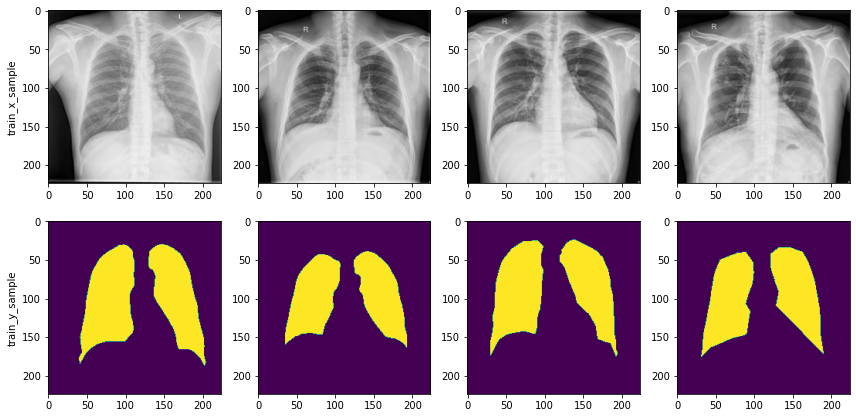

In [19]:
# 시각화
ncols, nrows = 4, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for i in range(ncols):
    img0 = train_sample_x[i].permute(1,2,0)
    img1 = train_sample_y[i].permute(1,2,0)[:,:,-1]
    
    axes[0,i].imshow(img0)
    axes[0,0].set_ylabel('train_x_sample')
    
    axes[1,i].imshow(img1)
    axes[1,0].set_ylabel('train_y_sample')
plt.tight_layout()
plt.show()

# 모형

In [20]:
from torchvision import models

In [21]:
ranges = {'vgg16' : ((0,5),(5,10),(10,17),(17,24),(24,31))}

In [22]:
models.vgg16(weights=True).features

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

5 단위로 합성곱 및 pooling 연산이 일어남

In [23]:
class VGGNet(nn.Module):
  def __init__(self,pretrained=True):
    super(VGGNet,self).__init__()
    self.ranges = ranges['vgg16']
    self.features = models.vgg16(weights=pretrained).features

  def forward(self,x):
    output = {}
    for idx in range(len(self.ranges)):
      for layer in range(self.ranges[idx][0],self.ranges[idx][1]):
        x = self.features[layer](x)
      output['x%d'%(idx+1)] = x
    return output

In [47]:
class FCN(nn.Module):    
  def __init__(self, pretrained_net, n_class):
    super(FCN,self).__init__()
    self.n_class = n_class
    self.pretrained_net = pretrained_net
    self.relu = nn.ReLU(inplace=True)
    self.deconv1 = nn.ConvTranspose2d(512,512,kernel_size=3,stride=2,padding=1,output_padding=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512,256,kernel_size=3,stride=2,padding=1,output_padding=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256,128,kernel_size=3,stride=2,padding=1,output_padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d(64,32,kernel_size=3,stride=2,padding=1,output_padding=1)
    self.bn5 = nn.BatchNorm2d(32)
    self.classifier = nn.Conv2d(32,n_class,kernel_size=1)

  def forward(self,x):
    output = self.pretrained_net(x)

    x5 = output['x5']
    x4 = output['x4']
    x3 = output['x3']
    x2 = output['x2']
    x1 = output['x1']

    # skip architecture
    score = self.bn1(self.relu(self.deconv1(x5)))
    score = score + x4
    score = self.bn2(self.relu(self.deconv2(score)))
    score = score + x3
    score = self.bn3(self.relu(self.deconv3(score)))
    score = score + x2
    score = self.bn4(self.relu(self.deconv4(score)))
    score = score + x1
    score = self.bn5(self.relu(self.deconv5(score)))
    score = self.classifier(score)

    return score


In [50]:
vgg16 = VGGNet()
model = FCN(vgg16,2).to(device)
model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FCN(
  (pretrained_net): VGGNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

# 학습

In [52]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.7 MB/s eta 0:00:00


In [53]:
import monai
from monai.config import print_config

In [57]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay=2e-4)
ce_loss = torch.nn.CrossEntropyLoss()
dice_loss = monai.metrics.DiceMetric(include_background=False,reduction='mean') # 배경에 관해서는 계산 x

In [59]:
def train(model, train_loader, optimizer):
  since = time.time()
  model.train()
  epoch_loss = 0

  for batch, (X,y) in enumerate(train_loader):
    step = batch + 1
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    output = model(X)
    loss = ce_loss(output, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    dice_output = torch.where(output>=0.5,1,0)
    dice_loss(y_pred=dice_output,y=y)

  epoch_loss /= step
  dice_score = dice_loss.aggregate().item()
  dice_loss.reset()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  return epoch_loss, dice_score

In [62]:
def evaluate(model, test_loader):
  model.eval()
  loss = 0
  with torch.no_grad():
    for batch, (X,y) in enumerate(test_loader):
      step = batch + 1
      X,y = X.to(device), y.to(device)
      output = model(X)

      loss += ce_loss(output,y).item()
      dice_output = torch.where(output>=0.5,1,0)
      dice_loss(y_pred=dice_output,y=y)

    loss /= len(test_loader)
    dice_score = dice_loss.aggregate().item()
    dice_loss.reset()

    return loss, dice_score


In [65]:
losses = {'train':[],'val':[]}
dice_scores = {'train':[],'val':[]}
best_metric, best_epoch = 999,-1

for epoch in range(1,11):
  train_loss, train_dice_score = train(model, train_loader, optimizer) 
  val_loss, val_dice_score = evaluate(model,valid_loader)

  losses['train'].append(train_loss)
  losses['val'].append(val_loss)
  dice_scores['train'].append(train_dice_score)
  dice_scores['val'].append(val_dice_score)

  print(f'[{epoch}] Train Loss: {train_loss:.6f}, Dice score: {train_dice_score:.6f}')
  print(f'[{epoch}] Test Loss: {val_loss:.6f}, Dice score: {val_dice_score:.6f}')

  if losses['val'][-1] < best_metric:
    best_metric = losses['val'][-1]
    best_epoch = epoch
    torch.save(model.state_dict(),model_save_path)
    print('Save model')

Training complete in 1m 19s
[1] Train Loss: 0.068220, Dice score: 0.943605
[1] Test Loss: 0.074353, Dice score: 0.943157
Save model
Training complete in 1m 28s
[2] Train Loss: 0.064311, Dice score: 0.945375
[2] Test Loss: 0.079432, Dice score: 0.942811
Training complete in 1m 5s
[3] Train Loss: 0.061958, Dice score: 0.945990
[3] Test Loss: 0.083560, Dice score: 0.950465
Training complete in 1m 6s
[4] Train Loss: 0.059309, Dice score: 0.947667
[4] Test Loss: 0.073966, Dice score: 0.939094
Save model
Training complete in 1m 27s
[5] Train Loss: 0.058625, Dice score: 0.948204
[5] Test Loss: 0.070494, Dice score: 0.941912
Save model
Training complete in 1m 6s
[6] Train Loss: 0.057526, Dice score: 0.948931
[6] Test Loss: 0.074899, Dice score: 0.948718
Training complete in 1m 6s
[7] Train Loss: 0.058972, Dice score: 0.948272
[7] Test Loss: 0.106027, Dice score: 0.873761
Training complete in 1m 5s
[8] Train Loss: 0.056955, Dice score: 0.949661
[8] Test Loss: 0.072495, Dice score: 0.922938
Trai

In [66]:
print(f"train completed, best_metric: {best_metric:.4f} \n" 
      f"at epoch: {best_epoch}")

train completed, best_metric: 0.0705 
at epoch: 5


## 시각화



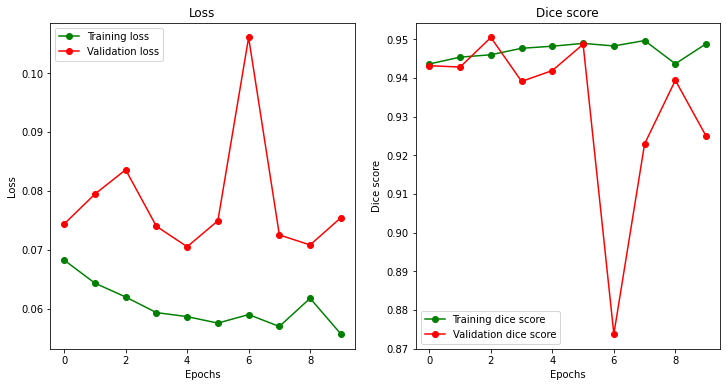

In [67]:
epochs = [i for i in range(len(losses['train']))]
train_loss = losses['train']
val_loss = losses['val']
train_dice = dice_scores['train']
val_dice = dice_scores['val']

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

ax[0].plot(epochs,train_loss,'g-o',label='Training loss')
ax[0].plot(epochs,val_loss,'r-o',label='Validation loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs,train_dice,'go-',label='Training dice score')
ax[1].plot(epochs,val_dice,'ro-',label='Validation dice score')
ax[1].set_title('Dice score')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Dice score')
plt.show()

# 평가

In [68]:
len_test = len(test_loader)

pred_dict = {'input':[],'target':[],'output':[]}

model.load_state_dict(torch.load(model_save_path))  
model.to('cpu')
model.eval()

with torch.no_grad():
  for i, (X,y) in enumerate(test_loader):
    output = model(X)
    output = torch.argmax(output,dim=1,keepdim=True)

    data = X[0].permute(1,2,0)
    target = y[0].permute(1,2,0)[:,:,-1]
    output_ = output[0].permute(1,2,0)[:,:,-1]

    pred_dict['input'].append(data)
    pred_dict['target'].append(target)
    pred_dict['output'].append(output_)

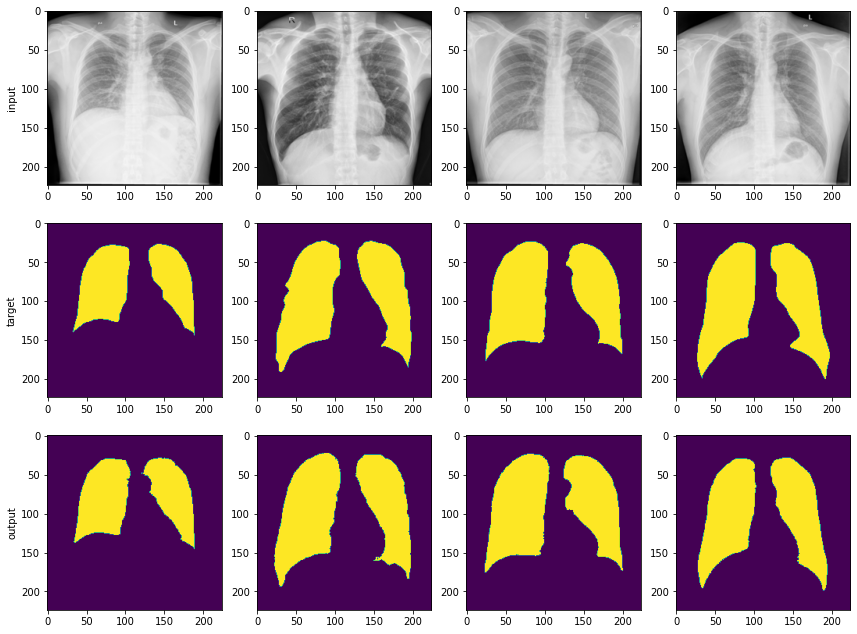

In [69]:
ncols, nrows = 4, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for i in range(ncols):
    axes[0,i].imshow(pred_dict['input'][i])
    axes[0,0].set_ylabel('input')

    axes[1,i].imshow(pred_dict['target'][i])
    axes[1,0].set_ylabel('target')

    axes[2,i].imshow(pred_dict['output'][i])
    axes[2,0].set_ylabel('output')

plt.tight_layout()
plt.show()